In [ ]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric

# GCN

In [34]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, ChebConv  # noqa

# for cora dataset
dataset = 'Cora'
path = osp.join(osp.dirname(osp.realpath('__file__')), '..', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]

# for karate dataset
# dataset = KarateClub()
# data = dataset[0]
# data.train_mask = torch.tensor(range(0,34), dtype=torch.long)
# data.val_mask = torch.tensor(range(0,34), dtype=torch.long)
# data.test_mask = torch.tensor(range(0,34), dtype=torch.long)

if False:
    gdc = T.GDC(self_loop_weight=1, normalization_in='sym',
                normalization_out='col',
                diffusion_kwargs=dict(method='ppr', alpha=0.05),
                sparsification_kwargs=dict(method='topk', k=128,
                                           dim=0), exact=True)
    data = gdc(data)


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16, cached=True,
                             normalize=True)
        self.conv2 = GCNConv(16, dataset.num_classes, cached=True,
                             normalize=True)
        # self.conv3 = GCNConv(dataset.num_features, dataset.num_classes, cached=True,
        #                      normalize=True)
        # self.conv1 = ChebConv(data.num_features, 16, K=2)
        # self.conv2 = ChebConv(16, data.num_features, K=2)

        self.reg_params = self.conv1.parameters()
        self.non_reg_params = self.conv2.parameters()
        #self.non_reg_params = self.conv3.parameters()

    def forward(self):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        # x = self.conv3(x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam([
    dict(params=model.reg_params, weight_decay=5e-4),
    dict(params=model.non_reg_params, weight_decay=0)
], lr=0.01)


def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


@torch.no_grad()
def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


best_val_acc = test_acc = 0
for epoch in range(1, 201):
    train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, train_acc, best_val_acc, test_acc))

Epoch: 001, Train: 0.3286, Val: 0.2520, Test: 0.2420
Epoch: 002, Train: 0.4214, Val: 0.2600, Test: 0.2660
Epoch: 003, Train: 0.6071, Val: 0.3160, Test: 0.3390
Epoch: 004, Train: 0.8429, Val: 0.5220, Test: 0.5510
Epoch: 005, Train: 0.8714, Val: 0.5220, Test: 0.5510
Epoch: 006, Train: 0.9143, Val: 0.5780, Test: 0.6030
Epoch: 007, Train: 0.9286, Val: 0.6540, Test: 0.6780
Epoch: 008, Train: 0.9571, Val: 0.6960, Test: 0.7250
Epoch: 009, Train: 0.9429, Val: 0.6980, Test: 0.7280
Epoch: 010, Train: 0.9500, Val: 0.6980, Test: 0.7280
Epoch: 011, Train: 0.9286, Val: 0.7060, Test: 0.7210
Epoch: 012, Train: 0.9143, Val: 0.7080, Test: 0.7300
Epoch: 013, Train: 0.9214, Val: 0.7080, Test: 0.7300
Epoch: 014, Train: 0.9214, Val: 0.7080, Test: 0.7300
Epoch: 015, Train: 0.9286, Val: 0.7140, Test: 0.7440
Epoch: 016, Train: 0.9286, Val: 0.7180, Test: 0.7400
Epoch: 017, Train: 0.9357, Val: 0.7240, Test: 0.7430
Epoch: 018, Train: 0.9429, Val: 0.7280, Test: 0.7470
Epoch: 019, Train: 0.9429, Val: 0.7300, Test: 

# GAT

In [35]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv

# for cora dataset
dataset = 'Cora'
path = osp.join(osp.dirname(osp.realpath('__file__')), '..', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]

# for karate dataset
# dataset = KarateClub()
# data = dataset[0]
# data.train_mask = torch.tensor(range(0,34), dtype=torch.long)
# data.val_mask = torch.tensor(range(0,34), dtype=torch.long)
# data.test_mask = torch.tensor(range(0,34), dtype=torch.long)


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GATConv(dataset.num_features, 8, heads=8, dropout=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GATConv(8 * 8, dataset.num_classes, heads=1, concat=True,
                             dropout=0.6)
        # self.conv3 = GATConv(dataset.num_features, dataset.num_classes, heads=1)

    def forward(self):
        x = F.dropout(data.x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, data.edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, data.edge_index)
        #x = self.conv3(data.x, data.edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


for epoch in range(1, 201):
    train()
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, *test()))

Epoch: 001, Train: 0.3214, Val: 0.2880, Test: 0.2590
Epoch: 002, Train: 0.3143, Val: 0.2840, Test: 0.2590
Epoch: 003, Train: 0.5429, Val: 0.5340, Test: 0.5050
Epoch: 004, Train: 0.7000, Val: 0.6640, Test: 0.6580
Epoch: 005, Train: 0.7643, Val: 0.6840, Test: 0.6950
Epoch: 006, Train: 0.7857, Val: 0.6720, Test: 0.6820
Epoch: 007, Train: 0.8357, Val: 0.6780, Test: 0.6820
Epoch: 008, Train: 0.8929, Val: 0.7180, Test: 0.7140
Epoch: 009, Train: 0.9000, Val: 0.7540, Test: 0.7520
Epoch: 010, Train: 0.9071, Val: 0.7440, Test: 0.7640
Epoch: 011, Train: 0.9071, Val: 0.7320, Test: 0.7410
Epoch: 012, Train: 0.9071, Val: 0.7260, Test: 0.7310
Epoch: 013, Train: 0.9214, Val: 0.7200, Test: 0.7250
Epoch: 014, Train: 0.9071, Val: 0.7140, Test: 0.7230
Epoch: 015, Train: 0.9000, Val: 0.7060, Test: 0.7090
Epoch: 016, Train: 0.9000, Val: 0.7040, Test: 0.7010
Epoch: 017, Train: 0.9000, Val: 0.6960, Test: 0.6790
Epoch: 018, Train: 0.9000, Val: 0.6980, Test: 0.6760
Epoch: 019, Train: 0.9143, Val: 0.7100, Test: 

# Node2Vec

Epoch: 01, Loss: 8.0950, Acc: 0.1700
Epoch: 02, Loss: 6.0501, Acc: 0.1870
Epoch: 03, Loss: 4.9423, Acc: 0.2220
Epoch: 04, Loss: 4.1267, Acc: 0.2560
Epoch: 05, Loss: 3.4707, Acc: 0.2980
Epoch: 06, Loss: 2.9550, Acc: 0.3230
Epoch: 07, Loss: 2.5456, Acc: 0.3560
Epoch: 08, Loss: 2.2091, Acc: 0.3700
Epoch: 09, Loss: 1.9521, Acc: 0.3930
Epoch: 10, Loss: 1.7364, Acc: 0.4270
Epoch: 11, Loss: 1.5679, Acc: 0.4440
Epoch: 12, Loss: 1.4289, Acc: 0.4800
Epoch: 13, Loss: 1.3152, Acc: 0.4990
Epoch: 14, Loss: 1.2282, Acc: 0.5190
Epoch: 15, Loss: 1.1608, Acc: 0.5410
Epoch: 16, Loss: 1.1044, Acc: 0.5710
Epoch: 17, Loss: 1.0611, Acc: 0.5990
Epoch: 18, Loss: 1.0232, Acc: 0.6130
Epoch: 19, Loss: 0.9941, Acc: 0.6250
Epoch: 20, Loss: 0.9708, Acc: 0.6390
Epoch: 21, Loss: 0.9515, Acc: 0.6400
Epoch: 22, Loss: 0.9369, Acc: 0.6540
Epoch: 23, Loss: 0.9221, Acc: 0.6580
Epoch: 24, Loss: 0.9108, Acc: 0.6700
Epoch: 25, Loss: 0.9031, Acc: 0.6720
Epoch: 26, Loss: 0.8944, Acc: 0.6680
Epoch: 27, Loss: 0.8866, Acc: 0.6710
E

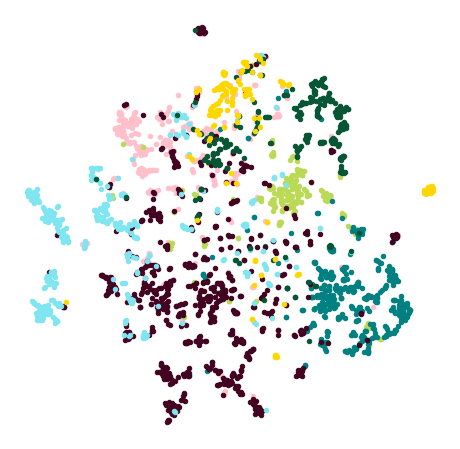

In [36]:
import os.path as osp

import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import KarateClub

# for cora dataset
dataset = 'Cora'
path = osp.join(osp.dirname(osp.realpath('__file__')), '..', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]

# for karate dataset
# dataset = KarateClub()
# data = dataset[0]
# data.train_mask = torch.tensor(range(0,34), dtype=torch.long)
# data.val_mask = torch.tensor(range(0,34), dtype=torch.long)
# data.test_mask = torch.tensor(range(0,34), dtype=torch.long)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10, num_negative_samples=1,
                 sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)


def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask], max_iter=150)
    return acc


for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)